# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [ ]:
import json
import sys
sys.path.append('../..')

from utils import validateJson

jsonData = json.load(open('recipes_valid.json'))
#validateJson.validateRecimeJson(jsonData)

print(jsonData.keys())

dict_keys(['title', 'ingredients', 'instructions'])


In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/'
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataPath = ''

In [2]:
import pickle
import pandas as pd

with open(dataPath + 'recipes_valid.pkl', 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())

Index(['title', 'ingredients', 'instructions'], dtype='object')


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
data = []

for recipeIndex, item in enumerate(pklData.iterrows()):
    rowData = {}
    for index, ingredient in item[1]['ingredients'].iterrows():
        for key in ingredient.keys():
            rowData[key+str(index)] = ingredient[key]
    data.append(rowData)
    #if recipeIndex == 25000:
    #    break

frame = pd.DataFrame(data)
del data


In [4]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

dropColumns = []
for column in frame.columns:
    if 'amount' in column:
        dropColumns.append(column)
frameStripped = frame.drop(columns=dropColumns)

#del pklData

frameStripped_cols = frameStripped.columns

enc = OneHotEncoder()
enc.fit(frameStripped)
sparseStrippedEncodedFrame = enc.transform(frameStripped)
sparseStrippedEncodedFrame_cols = enc.get_feature_names(frameStripped_cols)

sparseDroppedFrame = sparse.csr_matrix(frame[dropColumns])

sparseEncodedFrame = sparse.hstack([sparseDroppedFrame, sparseStrippedEncodedFrame])
sparseEncodedFrame_cols = [*dropColumns, *sparseStrippedEncodedFrame_cols]

#frameStrippedEncodedSki = pd.DataFrame(data=enc.transform(frameStripped).toarray(), columns=enc.get_feature_names(frameStripped.columns))

#del frameStripped
#frameEncodedSki = pd.concat([frame[dropColumns], frameStrippedEncodedSki], axis=1)
#frameEncodedSki_cols = frameEncodedSki.columns
#del frame
#del frameStrippedEncodedSki


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
sparseEncodedFrame.get_shape()

(97422, 64867)

## VAE
### Setup

In [7]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from cvae import VariationalAutoEncoder

# Import custom helper functions
from networkUtils import DataBuilder, CustomLoss, standardize_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Setup Datasets + Hyperparameters

In [8]:
train_data, test_data, scaler =  standardize_data(sparseEncodedFrame)
#del frameEncodedSki

AttributeError: ignored

In [7]:
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data, standardizer=scaler)
testdata_set=DataBuilder(test_data, standardizer=scaler)
#del train_data
#del test_data
#del scaler
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [8]:
D_in = testdata_set.x.shape[1]
H = 1024
H2 = 128
latent_dim = 32
model = VariationalAutoEncoder(D_in, H, H2, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

### Train Model

In [9]:
epochs = 100
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [11]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [12]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

====> Epoch: 5 Average training loss: 58130.1675
====> Epoch: 5 Average test loss: 54270.0393
====> Epoch: 10 Average training loss: 51867.6517
====> Epoch: 10 Average test loss: 49169.5577
====> Epoch: 15 Average training loss: 47083.0359
====> Epoch: 15 Average test loss: 44812.5426
====> Epoch: 20 Average training loss: 42908.7653
====> Epoch: 20 Average test loss: 41238.2412
====> Epoch: 25 Average training loss: 39125.8152
====> Epoch: 25 Average test loss: 38246.0959
====> Epoch: 30 Average training loss: 29265.2639
====> Epoch: 30 Average test loss: 25482.2442
====> Epoch: 35 Average training loss: 29249.7855
====> Epoch: 35 Average test loss: 25466.6361
====> Epoch: 40 Average training loss: 29237.2738
====> Epoch: 40 Average test loss: 25455.6456
====> Epoch: 45 Average training loss: 29228.5733
====> Epoch: 45 Average test loss: 25448.9361
====> Epoch: 50 Average training loss: 29222.2068
====> Epoch: 50 Average test loss: 25439.5240
====> Epoch: 55 Average training loss: 292

20
20


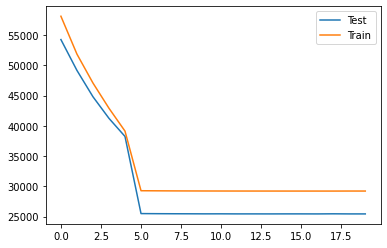

In [13]:
import matplotlib.pyplot as plt
print(len(test_losses))
print(len(train_losses))
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

In [14]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [15]:
scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch[0].cpu().numpy())
real_row = scaler.inverse_transform(testloader.dataset.x[0].cpu().numpy())

ValueError: ignored

In [16]:
df = pd.DataFrame(np.stack((recon_row, real_row)), columns = frameEncodedSki_cols)
df

NameError: ignored

### Draw random samples form latent space and generate new data

In [17]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [19]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data, columns = frameEncodedSki_cols)
df_fake.head(10)

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,amount10,amount11,amount12,amount13,amount14,amount15,amount16,amount17,amount18,amount19,unit0_,unit0_bushel,unit0_centimetre,unit0_cubic centimetre,unit0_cup,unit0_fluid ounce,unit0_gallon,unit0_gram,unit0_inch,unit0_kilogram,unit0_litre,unit0_ounce,unit0_package,unit0_peck,unit0_pinch,unit0_pint,unit0_pound-mass,unit0_quart,unit0_tablespoon,unit0_teaspoon,...,ingredient19_lemon - pepper seasoning,ingredient19_lemon juice,ingredient19_lemon wedges,ingredient19_lime wedges,ingredient19_miniature semisweet chocolate chips,ingredient19_natural bran,ingredient19_nutmeg,ingredient19_of fresh mint,ingredient19_oil,ingredient19_olive oil,ingredient19_olive oil flavored cooking spray,ingredient19_oriental sesame oil,ingredient19_paprika,ingredient19_parmesan cheese,ingredient19_parmigiano,ingredient19_pepper,ingredient19_pimiento,ingredient19_pita bread,ingredient19_pomegranate seeds,ingredient19_prosciutto,ingredient19_provolone cheese,ingredient19_red cabbage,ingredient19_red currant jelly,ingredient19_red pepper flakes,ingredient19_salt,ingredient19_salt & freshly ground black pepper,ingredient19_salt and black pepper,ingredient19_salt and pepper,ingredient19_semi - sweet chocolate baking squares,ingredient19_sharp cheddar cheese,ingredient19_sour cream,ingredient19_sugar,ingredient19_thyme,ingredient19_tomato chutney,ingredient19_vanilla,ingredient19_vanilla extract,ingredient19_vegetable oil,ingredient19_vinegar,ingredient19_watercress,ingredient19_nan
0,9.308043,33.136173,10.304247,0.304531,-50.814140,10.275233,460.382935,-15.814436,-17.255199,-36.992737,-138.828613,-71.928841,-143.327362,-98.595200,-101.558746,-105.176773,-104.236626,-103.818283,-103.095444,-101.093246,0.618673,-0.003804,0.005001,-0.012704,0.420531,-0.013756,-0.027336,0.011756,-0.008373,-0.019025,0.006080,0.029553,0.051451,-0.005072,0.016600,0.009041,-0.011021,0.036109,-0.083462,-0.038435,...,-0.004314,-0.001835,-0.052192,-0.017048,0.002443,-0.001219,-0.003065,-0.001374,0.462429,-0.010831,-0.002500,-0.003002,0.194907,-0.006614,-0.119316,0.001192,0.639771,-0.003174,-0.163361,0.745300,0.005857,-0.004937,-0.002770,0.610313,0.009110,-0.001114,0.002148,0.006472,-0.003380,0.000721,-0.598022,-0.001473,-0.002233,-0.600092,-0.004036,-0.000773,-0.003168,0.111973,0.004566,1.020724
1,-25.102407,-6.679283,-39.547131,-32.138653,-21.113867,23.997900,226.651123,4.610043,2.650764,-21.519192,-124.631409,-84.207535,-152.831085,-103.041206,-108.544739,-108.974709,-108.976662,-105.259369,-105.103630,-102.483459,0.199323,-0.003856,0.005729,-0.038480,0.217630,-0.014570,0.016398,-0.081440,-0.019800,-0.015213,-0.005870,0.147233,-0.012547,-0.004287,0.455184,0.020429,0.166386,-0.007861,0.121690,-0.025398,...,-0.005585,-0.004448,-0.626215,-0.477826,0.001560,-0.005105,-0.005084,-0.004085,0.242206,-0.008144,-0.003096,-0.005898,0.111341,-0.004506,-0.718548,0.001339,0.394573,-0.003573,-0.344665,0.070086,-0.002206,-0.004337,-0.003612,0.517725,0.001795,-0.005054,0.006804,0.001551,-0.002686,-0.003608,-0.308631,-0.003667,-0.007820,-0.255093,-0.004865,-0.001414,-0.003546,-0.139628,0.004774,1.035487
2,-41.871727,-52.052540,-19.597939,-35.040421,-36.927826,-66.859108,70.388481,-74.698898,-78.925079,-91.207237,-105.565521,-102.112724,-150.983093,-114.954140,-116.020912,-109.660927,-106.465836,-104.004402,-102.131287,-101.234367,0.169820,0.000465,-0.006393,0.022559,0.446779,0.031707,-0.020207,-0.040769,0.009745,0.012509,-0.005232,-0.109200,0.014734,0.002517,0.158054,0.036348,0.120595,-0.019129,0.136670,0.014303,...,-0.001130,-0.003879,0.125434,0.270073,-0.007266,-0.003651,-0.000554,-0.003169,0.331134,0.002963,-0.005836,-0.008124,-0.243170,-0.003557,0.058083,-0.005134,-0.000678,-0.001293,0.134204,-0.060457,0.000135,-0.001373,-0.010553,0.049339,-0.000443,-0.002285,-0.003296,-0.002739,0.000136,-0.009687,-0.056747,-0.003960,-0.002280,0.056089,0.000424,-0.006135,-0.001921,1.063386,-0.002986,1.015414
3,-1.882895,-40.430374,-9

In [20]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped_cols)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,amount10,amount11,amount12,amount13,amount14,amount15,amount16,amount17,amount18,amount19,unit0,ingredient0,unit1,ingredient1,unit2,ingredient2,unit3,ingredient3,unit4,ingredient4,unit5,ingredient5,unit6,ingredient6,unit7,ingredient7,unit8,ingredient8,unit9,ingredient9,unit10,ingredient10,unit11,ingredient11,unit12,ingredient12,unit13,ingredient13,unit14,ingredient14,unit15,ingredient15,unit16,ingredient16,unit17,ingredient17,unit18,ingredient18,unit19,ingredient19
0,9.308043,33.136173,10.304247,0.304531,-50.814140,10.275233,460.382935,-15.814436,-17.255199,-36.992737,-138.828613,-71.928841,-143.327362,-98.595200,-101.558746,-105.176773,-104.236626,-103.818283,-103.095444,-101.093246,,walnut halves,,strawberry muffin mix,,cream of coconut,cup,candied citron peel,,wasabi powder,,french - style ladyfinger cookies,cup,pecan nuts,,Oscar Mayer real bacon bits,centimetre,plain white flour,NaN,peanut butter chips,NaN,braeburn apples,NaN,fruit spread,NaN,red chili pepper flakes,NaN,caviar,NaN,hot chili peppers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lawry's Seasoned Salt,NaN,NaN
1,-25.102407,-6.679283,-39.547131,-32.138653,-21.113867,23.997900,226.651123,4.610043,2.650764,-21.519192,-124.631409,-84.207535,-152.831085,-103.041206,-108.544739,-108.974709,-108.976662,-105.259369,-105.103630,-102.483459,pinch,lean ground meat,,triple cream brie,,bread machine yeast,,dried currants,,cheddar cheese soup,,fingerling potatoes,cup,hot chili pepper,,low - sodium tamari,,peppercorn ranch dressing,metre,pickled jalapeno peppers,NaN,cayenne powder,NaN,chicory lettuce,NaN,NaN,NaN,NaN,NaN,fresh tarragon,NaN,sweetened flaked coconut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-41.871727,-52.052540,-19.597939,-35.040421,-36.927826,-66.859108,70.388481,-74.698898,-78.925079,-91.207237,-105.565521,-102.112724,-150.983093,-114.954140,-116.020912,-109.660927,-106.465836,-104.004402,-102.131287,-101.234367,cup,yellow cake layer,tablespoon,cooked ground beef,tablespoon,part - skim ricotta cheese,kilogram,refrigerated sugar cookie dough,NaN,dashi,NaN,green onions with tops,NaN,chicken stock cube,NaN,green lentils,NaN,sea scallops,NaN,canned chicken broth,NaN,wonton wrappers,NaN,crystallized ginger,NaN,dark sesame oil,NaN,top sirloin steak,NaN,NaN,NaN,saffron,NaN,lime zest,NaN,peanuts,NaN,NaN,NaN,vinegar
3,-1.882895,-40.430374,-9.922500,12.166541,16.195778,44.025063,-273.524841,31.478443,27.415627,12.550499,-28.959116,-29.056999,-124.418770,-89.428871,-102.442757,-103.273918,-101.339157,-104.182999,-103.207130,-101.102196,,backfin crab meat,,whole salmon,,coconut extract,decilitre,lemon jelly powder,,hershey nuggets chocolate candy bars with almonds,,Kraft Shredded Monterey Jack Cheese,teaspoon,fresh apple juice,,smoked bacon,centimetre,sugar - free chocolate,,mango,,instant vanilla pudding,NaN,green cherries,NaN,veal,NaN,pomegranate juice,NaN,butterscotch chips,NaN,NaN,NaN,NaN,NaN,smoked paprika,NaN,NaN,NaN,NaN
4,28.863880,33.169434,13.145253,19.035786,92.967888,13.686391,304.365234,-21.837055,-45.394554,-62.879833,-148.255997,-93.611107,-110.510696,-102.408302,-100.283356,-102.708817,-103.270233,-102.528069,-102.919899,-101.275414,cup,red kidney beans,cup,solid shortening,teaspoon,orange bell pepper,teaspoon,dried lemongrass,teaspoon,matzohs,cup,onion soup,cup,vanilla candy coating,,fat - free Italian salad dressing,NaN,piri - piri,NaN,nacho chips,NaN,dried breadcrumbs,NaN,Cool Whip Topping,NaN,beef short ribs,NaN,strawberry,NaN,pitted prunes,NaN,NaN,NaN,red cabbage,NaN,NaN,NaN,NaN,NaN,NaN
5,58.181618,63.807171,41.750717,45.366711,149.311447,29.042791,-319.906464,21.666534,-5.059434,-7.757035,168.029022,-25.551270,107.453667,-33.327988,-41.733852,-51.633221,-62.681530,-73.497940,-79.490250,-89.601685,tablespoon,yellow corn flour,,fenugreek seeds,,boneless beef top round steaks,,red capsicums,,portabella mushroom,,chili oil,,vegetable bouillon cubes,,chablis,,capellini,metre,ginger syrup,package,pork

In [21]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"[9.308043479919434, , walnut halves]","[33.136173248291016, , strawberry muffin mix]","[10.30424690246582, , cream of coconut]","[0.3045310378074646, cup, candied citron peel]","[-50.81414031982422, , wasabi powder]","[10.275233268737793, , french - style ladyfing...","[460.3829345703125, cup, pecan nuts]","[-15.814435958862305, , Oscar Mayer real bacon...","[-17.255199432373047, centimetre, plain white ...","[-36.99273681640625, nan, peanut butter chips]","[-138.82861328125, nan, braeburn apples]","[-71.92884063720703, nan, fruit spread]","[-143.32736206054688, nan, red chili pepper fl...","[-98.59519958496094, nan, caviar]","[-101.55874633789062, nan, hot chili peppers]","[-105.17677307128906, nan, nan]","[-104.23662567138672, nan, nan]","[-103.81828308105469, nan, nan]","[-103.09544372558594, nan, Lawry's Seasoned Salt]","[-101.09324645996094, nan, nan]"
1,"[-25.102407455444336, pinch, lean ground meat]","[-6.679283142089844, , triple cream brie]","[-39.5471305847168, , bread machine yeast]","[-32.13865280151367, , dried currants]","[-21.113866806030273, , cheddar cheese soup]","[23.997900009155273, , fingerling potatoes]","[226.651123046875, cup, hot chili pepper]","[4.610043048858643, , low - sodium tamari]","[2.650763511657715, , peppercorn ranch dressing]","[-21.51919174194336, metre, pickled jalapeno p...","[-124.63140869140625, nan, cayenne powder]","[-84.20753479003906, nan, chicory lettuce]","[-152.83108520507812, nan, nan]","[-103.04120635986328, nan, nan]","[-108.54473876953125, nan, fresh tarragon]","[-108.9747085571289, nan, sweetened flaked coc...","[-108.9766616821289, nan, nan]","[-105.25936889648438, nan, nan]","[-105.10363006591797, nan, nan]","[-102.48345947265625, nan, nan]"
2,"[-41.871726989746094, cup, yellow cake layer]","[-52.05253982543945, tablespoon, cooked ground...","[-19.597938537597656, tablespoon, part - skim ...","[-35.04042053222656, kilogram, refrigerated su...","[-36.927825927734375, nan, dashi]","[-66.8591079711914, nan, green onions with tops]","[70.38848114013672, nan, chicken stock cube]","[-74.69889831542969, nan, green lentils]","[-78.92507934570312, nan, sea scallops]","[-91.20723724365234, nan, canned chicken broth]","[-105.56552124023438, nan, wonton wrappers]","[-102.11272430419922, nan, crystallized ginger]","[-150.98309326171875, nan, dark sesame oil]","[-114.95413970947266, nan, top sirloin steak]","[-116.02091217041016, nan, nan]","[-109.66092681884766, nan, saffron]","[-106.46583557128906, nan, lime zest]","[-104.00440216064453, nan, peanuts]","[-102.13128662109375, nan, nan]","[-101.23436737060547, nan, vinegar]"
3,"[-1.8828948736190796, , backfin crab meat]","[-40.43037414550781, , whole salmon]","[-9.922499656677246, , coconut extract]","[12.16654109954834, decilitre, lemon jelly pow...","[16.195777893066406, , hershey nuggets chocola...","[44.025062561035156, , Kraft Shredded Monterey...","[-273.52484130859375, teaspoon, fresh apple ju...","[31.478443145751953, , smoked bacon]","[27.415626525878906, centimetre, sugar - free ...","[12.550498962402344, , mango]","[-28.959115982055664, , instant vanilla pudding]","[-29.05699920654297, nan, green cherries]","[-124.41876983642578, nan, veal]","[-89.42887115478516, nan, pomegranate juice]","[-102.44275665283203, nan, butterscotch chips]","[-103.27391815185547, nan, nan]","[-101.33915710449219, nan, nan]","[-104.18299865722656, nan, smoked paprika]","[-103.2071304321289, nan, nan]","[-101.1021957397461, nan, nan]"
4,"[28.863880157470703, cup, red kidney beans]","[33.16943359375, cup, solid shortening]","[13.14525318145752, teaspoon, orange bell pepper]","[19.035785675048828, teaspoon, dried lemongrass]","[92.96788787841797, teaspoon, matzohs]","[13.68639087677002, cup, onion soup]","[304.365234375, cup, vanilla candy coating]","[-21.837055206298828, , fat - free Italian sal...","[-45.394554138183594, nan, piri - piri]","[-62.87983322143555, nan, nacho chips]","[-148.25599670